In [1]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

In [2]:
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))

spark = SparkSession \
    .builder \
    .getOrCreate()

### Reading the Dataset

In [3]:
df = (spark.read
          .format("csv")
          .option('header', 'true')
          .load("./datasets/uci-diabetes.csv"))

In [4]:
from pyspark.sql.functions import col
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import Normalizer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.tuning import CrossValidatorModel
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline

### Selecting Feature from Dataset and casting it into required Dtype

In [5]:
columns  = df.columns

dataset = df.select(col(columns[1]).cast('float'),
                    col(columns[2]).cast('float'),
                    col(columns[3]).cast('string'),
                    col(columns[4]).cast('float'),
                   )

### Feature Transformation

In [6]:
indexer = StringIndexer(inputCol="code", outputCol="codeIndex")
encoder = OneHotEncoder(inputCol="codeIndex", outputCol="codeVec")
vectorAssembler = VectorAssembler(inputCols=['value','codeVec'],
                                  outputCol="features")
#normalizer = Normalizer(inputCol="features", outputCol="features_norm", p=1.0)
scaler = StandardScaler(inputCol="features", outputCol="features_norm")
pipeline = Pipeline(stages=[indexer, encoder, vectorAssembler, scaler])
final_df = pipeline.fit(dataset).transform(dataset)

### Splitting the Dataset into traininng data and test data

In [7]:
(training_data, test_data) = final_df.randomSplit([0.8,0.2],seed=0)

### Building model

In [8]:
lr = LogisticRegression()
param_grid = (ParamGridBuilder()
              .baseOn({lr.labelCol : 'Class'})
              .baseOn([lr.predictionCol, 'pred_lr'])
              .baseOn([lr.featuresCol, 'features_norm'])
              .addGrid(lr.regParam, [0.01,0.1,1,10,20])
              .addGrid(lr.elasticNetParam, [0,1]).build())

evaluator = BinaryClassificationEvaluator(labelCol= 'Class',rawPredictionCol= 'pred_lr')


cv = CrossValidator(estimator=lr, estimatorParamMaps=param_grid, evaluator=evaluator,seed=0,parallelism=4)

### Training the Model

In [9]:
cvModel = cv.fit(training_data)

In [10]:
cvModel.avgMetrics

[0.9996919315938355,
 0.9993714940005729,
 0.9996919315938355,
 0.9529507211574884,
 0.999645929201711,
 0.5,
 0.5429492114795855,
 0.5,
 0.5,
 0.5]

### Evaluating Trained Model Using Different Evaluation Metrics

In [11]:
evaluator.evaluate(cvModel.transform(test_data),{evaluator.metricName: 'areaUnderROC'})

0.9998175848230573

In [12]:
evaluator.evaluate(cvModel.transform(test_data), {evaluator.metricName : 'areaUnderPR'})

0.9996817313812858

### Best Params

In [13]:
cvModel.bestModel.getRegParam()

0.01

In [14]:
cvModel.bestModel.getElasticNetParam()

0.0

### Saving the Trained Model

In [22]:
path= r'./SavedModel/lr_model'
cvModel.save(path)

### Loading the Trained Model

In [23]:
#lr_model= CrossValidatorModel.read().load(path)

### Result Summary

In [15]:
import pandas as pd

summary_= {
    'areaUnderPR' : evaluator.evaluate(cvModel.transform(test_data), {evaluator.metricName : 'areaUnderPR'}),
    'areaUnderROC' :evaluator.evaluate(cvModel.transform(test_data),{evaluator.metricName: 'areaUnderROC'})
}
summary= pd.Series(summary_)
summary

areaUnderPR     0.999682
areaUnderROC    0.999818
dtype: float64

### Plotting ROC-AUC Curve , PR Curve and Feature Coefficients

In [16]:
import matplotlib.pyplot as plt
%matplotlib notebook
import numpy as np

In [17]:
lr_model = cvModel.bestModel.summary
roc= lr_model.roc.toPandas()

<IPython.core.display.Javascript object>


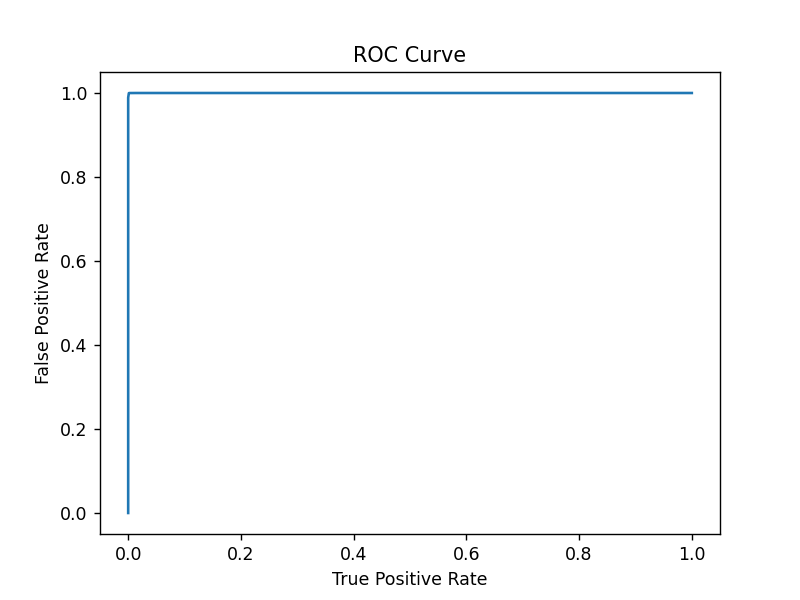

Training set areaUnderROC: 0.9998175848230573


In [18]:
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(summary.areaUnderROC))

<IPython.core.display.Javascript object>


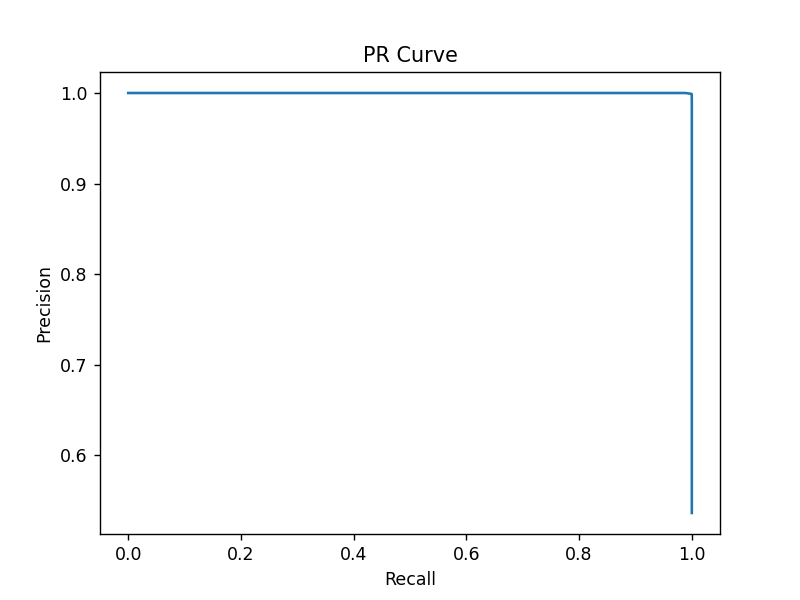

Training set areaUnderPR: 0.9996817313812858


In [19]:
pr = lr_model.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title('PR Curve')
plt.show()
print('Training set areaUnderPR: ' + str(summary.areaUnderPR))

In [20]:
#Features used to train model

features=[
    'Value',
    'Regular insulin dose',
    'NPH insulin dose',
    'UltraLente insulin dose',
    'Unspecified blood glucose measurement',
    'Unspecified blood glucose measurement',
    'Pre-breakfast blood glucose measurement',
    'Post-breakfast blood glucose measurement',
    'Pre-lunch blood glucose measurement',
    'Post-lunch blood glucose measurement',
    'Pre-supper blood glucose measurement',
    'Post-supper blood glucose measurement',
    'Pre-snack blood glucose measurement',
    'Hypoglycemic symptoms',
    'Typical meal ingestion',
    'More-than-usual meal ingestion',
    'Less-than-usual meal ingestion',
    'Typical exercise activity',
    'More-than-usual meal ingestion'
]

#Coefficients of different features of trained model
coeff = cvModel.bestModel.coefficients

<IPython.core.display.Javascript object>


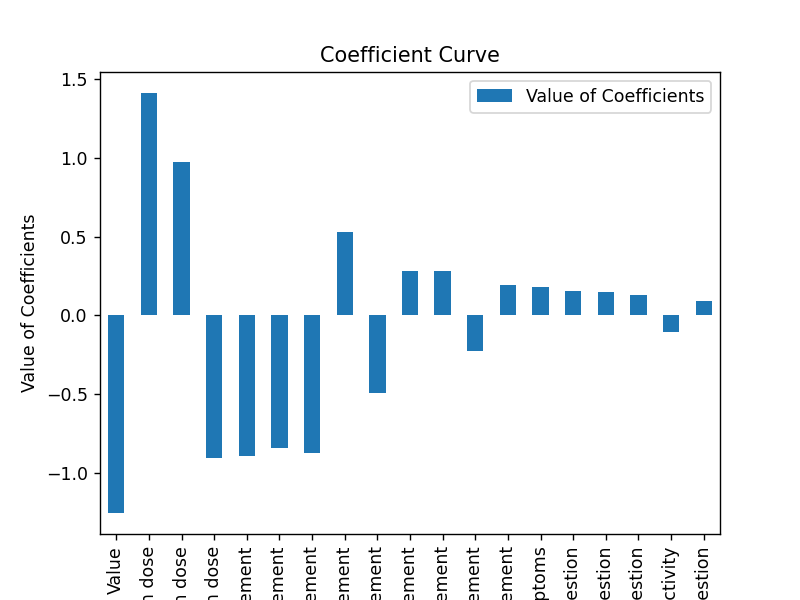

<AxesSubplot:title={'center':'Coefficient Curve'}, xlabel='Features', ylabel='Value of Coefficients'>

In [21]:
series = pd.Series(coeff,features)
df = pd.DataFrame(series,columns=['Value of Coefficients'])
df.plot.bar(title='Coefficient Curve',ylabel='Value of Coefficients',xlabel='Features')